# **Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"**

Nhóm 3:
1. 1712401 - Hồ Trường Giang - TruongGiangBT
2. 1712575 - Hoàng Xuân Long - dralong10
3. 18120249 - Hồ Minh Trí - Crys-Zz0o0
4. 18120374 - Nguyễn Minh Hiếu - templarassVN

Link thùng chứa Github của nhóm: [Link](https://github.com/templarassVN/Team-3_KHDLUD_K18)

## Mô tả bài toán

- Là cuộc thi dự đoán đội thắng và đội thua trong giải đấu bóng rổ nam NCAA năm 2021 (2020-2021) (2021 NCAA Division I Men's Basketball Tournament). [Link](https://www.kaggle.com/c/ncaam-march-mania-2021)
- Cuộc thi chia làm 2 giai đoạn:
  - Giai đoạn 1: Ban tổ chức sẽ cung cấp dữ liệu các trận đấu của các đội ở các mùa giải trước đến mùa giải 2019. Mục đích là để người tham gia có dữ liệu để xây dựng và thử nghiệm các mô hình.
  - Giai đoạn 2: Ban tổ chức sẽ cung cấp thêm dữ liệu về các đội được tham gia giải đấu năm 2021. Người tham gia sẽ tiến hành dự đoán và submit kết quả.
- Tổng quan về giải đấu:
  - Giải đấu gồm 68 đội tham gia chia đều ở 4 khu vực.
  - 8 đội First-Four sẽ thi đấu 4 trận đấu đầu tiên để tranh quyền đi tiếp => Còn lại 64 đội (Mỗi khu cực có 16 đội).
  - 16 đội trong mỗi khu vực sẽ đấu loại trực tiếp theo quy định của giải đấu và chọn ra đội thắng cuộc đại diện cho khu vực thi đấu ở vòng Final Four. Tại vòng Final Four, 4 đội đại diện cho 4 khu vực tiếp tục loại trực tiếp nhau và chọn ra người thắng chung cuộc. 
  - Tổng cộng sẽ có 67 trận đấu (gồm 4 trận First-Four, 15 trận đấu loại khu vực * 4 khu vực, 3 trận Final Four).
- Mô hình bài toán: Dựa vào các thông số thi đấu và thành tích. Ta sẽ thực hiện huấn luyện mô hình với input đầu vào là ID 2 đội (TeamIdA,TeamIdB) và các thuộc tính được rút trích của mỗi đội. Nhãn của mỗi cặp đấu có giá trị là 0 hoặc 1 (0 - đội A thua; 1 - đội A thắng)
- Input bài toán: Đầu vào bài toán là danh sách 68 đội tham gia giải đấu, về mặt lý thuyết ta sẽ có 68*67/2 = 2278 cặp đấu khác nhau. Ta sẽ dự đoán kết quả của 2278 cặp đấu.
- Output: Xác suất đội A thắng đội B.
- Cấu trúc file Submission gồm:
  - Id: [Mùa giải]_ [TeamIdA]_[TeamIdB]. Ex: 2021_1101_1102
  - Pred: Xác suất đội A thắng đội B
- Đánh giá kết quả: Kết quả dự đoán được đánh giá bằng hàm Log Loss.
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

## Giải quyết bài toán

- Nhóm đã tìm hiểu và cài đặt lại [giải pháp của tác giả kazukim](https://www.kaggle.com/c/ncaam-march-mania-2021/discussion/230946), đứng thứ 4 private leaderboard với score là 0.56346.
- Nhóm chọn giải này vì đây là giải pháp giành thứ hạng cao trong cuộc thi, tác giả có đề ra những đặc trưng hiệu quả trong việc dự đoán kết quả.

### I. Nạp dữ liệu và thư viện cần thiết

In [1]:
!gdown --id 1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
!gdown --id 1Bwe5QinxXItR6g5ODd8AGFYeHQR1xNJ-
!unzip ncaam-march-mania-2021.zip

Downloading...
From: https://drive.google.com/uc?id=1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
To: /content/ncaam-march-mania-2021.zip
100% 44.7M/44.7M [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bwe5QinxXItR6g5ODd8AGFYeHQR1xNJ-
To: /content/2021NCAA.csv
100% 895/895 [00:00<00:00, 1.50MB/s]
Archive:  ncaam-march-mania-2021.zip
replace MDataFiles_Stage1/Cities.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
# Load các thư viện cần thiết
!pip install lightgbm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

### II. Đọc dữ liệu

- Giải pháp hiện tại nhóm đang làm sử dụng dữ liệu từ 4 file csv: 
  - MMasseyOrdinals.csv
    - Mô tả: Là danh sách thứ hạng của các đội kể từ mùa giải 2003 dựa trên các hệ thống xếp hạng.
    - Thuộc tính:
      - Season: năm của mùa giải.
      - RatingDayNum: ngày trong mùa giải đó (Ngày bắt đầu mùa giải => RatingDayNum = 0).
      - SystemName: tên hệ thống xếp hạng, gồm 3 chữ cái in hoa.
      - TeamID: mã số của đội, gồm số có 4 chữ số, bắt đầu từ 1101.
      - OrdinalRank: thứ hạng.
  - MNCAATourneySeeds.csv
    - Mô tả: Xác định hạt giống của các đội tham gia giải đấu ở các mùa giải.
    - Thuộc tính:
      - Season, Team ID.
      - Seed: chuỗi gồm 3 hoặc 4 kí tự, kí tự đầu tiên ứng với mã khu vực của đội, 2 kí tự số tiếp theo là hạng hạt giống của đội, kí tự thứ 4 (nếu có) để phân biệt đội sẽ tham gia First-Four (Ví dụ: W11a - đội này xếp hạng hạt giống 11 trong khu vực W về sẽ thi đấu First-Four).
  - MRegularSeasonDetailedResults.csv
    - Mô tả: Cung cấp kết quả chi tiết của các trận đấu trước giải đấu (DayNum < 132), bao gồm điểm số và thông số trận đấu của các cặp đấu.
    - Thuộc tính:
      - Season
      - WTeamID, LTeamID: ID của đội thắng/đội thua.
      - DayNum: ngày thi đấu.
      - WScore, LScore: số điểm ghi được của đội thắng/ đội thua.
      - WLoc: đội được chơi trên sân: H - sân nhà, A - sân khách, N - sân trung lập.
      - NumOT: thời gian bù giờ.
      - WFGM, WFGA, WFGM3, WFGA3, WFTM, WFTA, WOR, WDR, WAst, WTO, WStl, WBlk, WPF: các thông số trận đấu của đội thắng. Tương tự, đội thua có kí tự 'L' ở đầu. 
  - MNCAATourneyCompactResults.csv
    - Mô tả: Cung cấp kết quả rút gọn của các trận đấu trong mùa giải, gồm điểm số của các cặp đấu.
    - Thuộc tính:
      - Season, WTeamID, LTeamID, DayNum, WScore, LScore, WLoc, NumOT

In [3]:
datasets_path = './MDataFiles_Stage2/'
os.listdir('./MDataFiles_Stage2/')

['MSampleSubmissionStage2.csv',
 'MNCAATourneyDetailedResults.csv',
 'MRegularSeasonCompactResults.csv',
 'MTeamCoaches.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSeasons.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'Conferences.csv',
 'Cities.csv',
 'MTeamSpellings.csv',
 'MTeams.csv',
 'MTeamConferences.csv',
 'MRegularSeasonDetailedResults.csv',
 'MConferenceTourneyGames.csv',
 'MMasseyOrdinals.csv',
 'MGameCities.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneySeeds.csv',
 'MSecondaryTourneyTeams.csv',
 'MNCAATourneySlots.csv']

In [4]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RatingDayNum':'DayNum'})
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
regular_results = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')

### III. Prerocessing, Feature Extraction

#### 1. Tính trung bình tất cả hệ thống Rank, chuyển đồi sang Rating
- Dựa vào bảng MMasseyOrdinals, tính thứ hạng trung bình ở các hệ thống Ranking của các đội. Tạo ra thêm thuộc tính Rating để đánh giá các đội dựa vào thứ hạng của họ
* **INPUT**: Nội dung MMasseyOrdinals.csv có các cột: **Season; RankingDayNum;	SystemName;	TeamID;	OrdinalRank**
* **OUTPUT**: Chỉ lấy các cột **Season;	TeamID;	OrdinalRank;	Rating** với
    * Các sample là dùng GroupBy().last() có đặc điểm là RankingDayNum >= 133
    * OrdinalRank là lấy mean (dùng groupby SystemName và ID) 
    * Rating = 100 - 4 x log({OrdinalRankX}) 

In [5]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RatingDayNum':'DayNum'})
ordinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4339985,2021,133,WOB,1467,233
4339986,2021,133,WOB,1468,176
4339987,2021,133,WOB,1469,290
4339988,2021,133,WOB,1470,256


In [6]:
ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()

,SystemName,Season,TeamID,RankingDayNum,OrdinalRank
0,7OT,2012,1102,133,146
1,7OT,2012,1103,133,80
2,7OT,2012,1104,133,35
3,7OT,2012,1105,133,338
4,7OT,2012,1106,133,300
...,...,...,...,...,...
349598,ZAM,2019,1462,133,70
349599,ZAM,2019,1463,133,87
349600,ZAM,2019,1464,133,242
349601,ZAM,2019,1465,133,198


In [7]:
#Lấy thứ hạn cuối cùng (thường DayNum=133) theo nhóm
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
# Tạo bảng gồm Season, TeamID, OrdinalRank; với OrdinalRank là thứ hạn trung bình trên các SystemName
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
# Thêm thuộc tính Rating
ordinals['Rating'] = 100 - 4*np.log(ordinals['OrdinalRank'])
ordinals

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,79.850662
1,2003,1103,168.705882,79.487373
2,2003,1104,36.638889,85.595559
3,2003,1105,308.735294,77.070063
4,2003,1106,260.911765,77.743271
...,...,...,...,...
6539,2021,1467,240.490566,78.069277
6540,2021,1468,180.288462,79.221767
6541,2021,1469,314.666667,76.993944
6542,2021,1470,252.823529,77.869233


Text(0.5, 1.0, 'Rating')

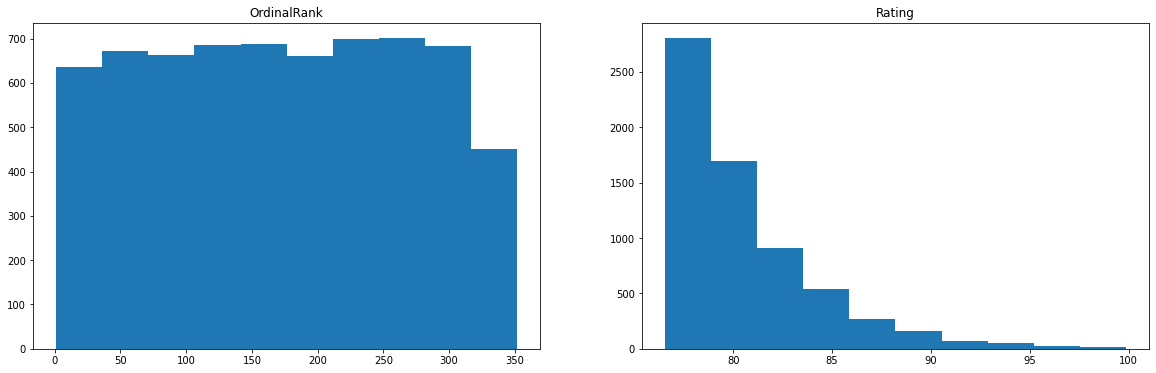

In [8]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(ordinals["OrdinalRank"])
ax1.set_title("OrdinalRank")
ax2.hist(ordinals["Rating"])
ax2.set_title("Rating")

***[Explain]***:

Trước đó ta thấy: Miền giá trị của OrdinalRank (thứ hạng) nằm trong [1-351]. Nhằm tránh mô hình phức tạp thì tác giả đã dùng hàm để biến đổi các biến:

$$\textrm{Y} = 100 - 4 \times log({X}) $$

**[1-351] -> [100 - 89]**, mong muốn của tác giả là thứ hạng càng cao thì Rating càng cao.

Ngoài ra, rõ ràng có sự khác biệt giữa các thứ hạng từ thấp tới cao.


#### 2. Tính số trận thắng/thua của đội trong mùa giải
- Dựa vào bảng *MRegularSeasonDetailedResults*, tính số trận thắng / trận thua của các đội trong mùa giải
* **INPUT**: *MRegularSeasonDetailedResults.csv* có rất nhiều cột 
* **OUTPUT**: bảng win_lose gồm các cột **Season;	TeamID;	NumWins;	NumLoses**

In [9]:
regular_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96682,2021,132,1104,80,1261,79,N,0,33,76,12,36,2,5,16,31,16,9,4,8,15,30,74,10,27,9,13,15,26,10,5,6,5,13
96683,2021,132,1159,85,1259,72,H,0,31,59,14,23,9,14,6,20,18,8,9,1,15,29,62,5,22,9,16,12,19,12,12,2,1,13
96684,2021,132,1222,91,1153,54,N,0,37,66,11,23,6,7,10,26,24,6,8,4,16,18,65,8,33,10,15,14,17,11,10,2,5,12
96685,2021,132,1228,91,1326,88,N,1,29,64,9,21,24,32,13,27,15,10,5,2,23,29,65,8,25,22,30,8,27,11,8,7,4,26


In [10]:
# Đếm số tận thắng
num_win = regular_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
# Đếm số trận thua
num_lose = regular_results.groupby(['Season', 'LTeamID']).count()
num_lose = num_lose.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLoses", "LTeamID": "TeamID"})
# Ghép 2 bảng lại
win_lose = pd.merge(num_win, num_lose, how='outer', on=['Season', 'TeamID']).fillna(0).sort_values(by=['Season','TeamID']).reset_index(drop=True)
win_lose

,Season,TeamID,NumWins,NumLoses
0,2003,1102,12.0,16.0
1,2003,1103,13.0,14.0
2,2003,1104,17.0,11.0
3,2003,1105,7.0,19.0
4,2003,1106,13.0,15.0
...,...,...,...,...
6529,2021,1467,9.0,9.0
6530,2021,1468,11.0,7.0
6531,2021,1469,6.0,13.0
6532,2021,1470,5.0,10.0


Text(0.5, 1.0, 'NumLoses')

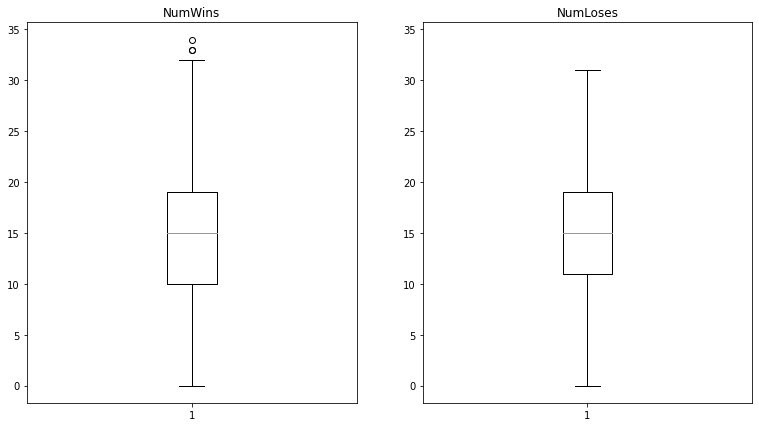

In [11]:
f = plt.figure(figsize=(13,7))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122,sharey=ax1)

ax1.boxplot(win_lose["NumWins"])
ax1.set_title("NumWins")
ax2.boxplot(win_lose["NumLoses"])
ax2.set_title("NumLoses")

***[Explain]***

Có 1 số đội thắng nhiều hơn hẳn => Winrate sẽ cao hơn

#### 3. Thống kê trung bình số liệu của đội trong mỗi mùa giải
- Dựa vào bảng MRegularSeasonDetailedResults, thống kê số liệu trận đấu trung bình của đội trong mùa giải.

***Bước 1:*** 
* **INPUT**: MRegularSeasonDetailedResults.csv có rất nhiều cột ghi lại thông số từng trận mỗi mùa
* **OUPUT**: *wteam_stats* Tính trung bình thông số (mỗi Season) của các đội, chỉ tính trận thắng 

***Bước 2:*** 
* **INPUT**: MRegularSeasonDetailedResults.csv có rất nhiều cột ghi lại thông số từng trận mỗi mùa
* **OUPUT**: *lteam_stats* Tính trung bình thông số (mỗi Season) của các đội, chỉ tính trận thua

***Bước 3:*** 
* **INPUT**: Gom *wteam_stats* và *lteam_stats*
* **OUPUT**: Trung bình thông số mỗi đội từ 2 bảng trên

*Bước 1* 

In [12]:
# Tính trung bình số liệu trận thắng của mỗi đội theo mùa
wteam_stats = regular_results.groupby(['Season', 'WTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thua
wteam_stats = wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                                'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',], axis=1)
# Đổi tên các thuộc tính của đội thắng thành tên chung
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM',
                                        'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA',
                                        'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,68.750000,53.166667,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,19.333333,16.916667,11.083333,7.333333,2.833333,16.083333
1,2003,1103,87.769231,78.384615,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,21.461538,17.692308,12.538462,7.307692,1.846154,20.461538
2,2003,1104,74.705882,61.529412,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,26.411765,14.000000,13.058824,7.235294,4.176471,16.470588
3,2003,1105,79.428571,66.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,25.857143,15.857143,18.000000,11.285714,2.000000,19.428571
4,2003,1106,68.307692,57.923077,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,28.000000,13.000000,17.692308,9.384615,3.769231,18.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,2021,1467,71.000000,61.777778,25.888889,53.000000,7.111111,21.777778,12.111111,17.888889,5.777778,25.000000,13.444444,13.888889,8.222222,3.888889,3.555556
6524,2021,1468,76.000000,62.363636,28.363636,55.181818,6.636364,18.454545,12.636364,16.181818,7.545455,21.636364,15.909091,10.636364,7.181818,2.272727,1.636364
6525,2021,1469,76.666667,71.833333,25.833333,59.166667,6.833333,19.833333,18.166667,23.500000,7.500000,23.833333,15.000000,12.666667,7.333333,1.666667,3.333333
6526,2021,1470,69.000000,56.200000,24.000000,50.800000,5.800000,12.800000,15.200000,18.400000,3.800000,22.800000,14.400000,8.000000,6.200000,2.000000,15.000000


*Bước 2:* 

In [13]:
# Tính trung bình số liệu trận thua của mỗi đội theo mùa
lteam_stats = regular_results.groupby(['Season', 'LTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thắng
lteam_stats = lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
                                'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)
# Đổi tên các thuộc tính của đội thua thành tên chung
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM',
                                        'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA',
                                        'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,59.875000,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,14.937500,10.062500,11.687500,4.937500,1.000000,20.750000
1,2003,1103,77.928571,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,18.500000,12.928571,12.714286,7.214286,2.785714,19.285714
2,2003,1104,70.363636,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,20.090909,9.181818,13.636364,5.636364,3.181818,20.454545
3,2003,1105,80.421053,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,22.105263,14.052632,18.894737,8.578947,2.105263,20.526316
4,2003,1106,68.800000,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,20.266667,10.533333,16.466667,7.466667,2.600000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,2021,1467,71.555556,61.555556,22.333333,54.444444,6.888889,22.444444,10.000000,15.444444,5.777778,19.222222,10.555556,12.111111,7.777778,3.666667,11.777778
6527,2021,1468,77.571429,67.142857,25.571429,53.428571,5.857143,14.857143,10.142857,14.428571,5.428571,17.000000,14.142857,11.142857,5.714286,1.714286,4.285714
6528,2021,1469,81.153846,63.461538,22.230769,57.230769,5.384615,19.615385,13.615385,19.076923,7.769231,22.846154,14.153846,16.461538,6.461538,2.230769,4.769231
6529,2021,1470,74.100000,61.300000,21.000000,50.900000,5.300000,15.500000,14.000000,19.900000,4.700000,18.800000,9.800000,12.400000,7.000000,2.400000,2.600000


*Bước 3*

In [14]:
# Ghép 2 số liệu của các trận thắng và thua lại
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
# Tính trung bình
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000


***[EXPLAIN:]***

Vì sao lại chọn mấy thuộc tính này

Theo  [Wiki](https://en.wikipedia.org/wiki/Basketball_statistics) và [Basketball Statistics Definitions](https://www.breakthroughbasketball.com/stats/definitions.html) thì người ta sử dụng các tham số này để đánh giá một cầu thủ (hoặc khả năng của một đội)
* FGM	FGA: (Feild Goal Made | Attempt)
* FGM3 FGA3	: (3 point) [Image](https://www.wikihow.com/images/thumb/3/3b/Shoot-a-Three-Pointer-Step-1-Version-7.jpg/v4-460px-Shoot-a-Three-Pointer-Step-1-Version-7.jpg.webp)
* FTM	FTA: (Free Throw) [Image](https://media.istockphoto.com/vectors/man-shooting-a-basketball-into-a-hoop-and-scoring-from-free-throw-vector-id1303771934?k=20&m=1303771934&s=612x612&w=0&h=R7sT2iTMIMZ_DSiKVl99l1KXj3BUZP6LpXf_JiE_uho=)
* OR	DR: (Offensive | Defensive) Rebound [Link](https://www.rookieroad.com/basketball/stats/rebounds/)
*	Ast:	(Assist) Hỗ trợ ghi điểm 
* TO: (TurnOver) Phản công thành công khi đối phương mất cơ hội	
* Stl: (Steal) Cướp bóng thành công
* Blk: (Block) Chặn bóng thành công
* PF: (Personal Fouls)


#### 4. Tính và thêm các thuộc tính Scoregap, FG%, 3P%, FT%, TR, TS%, eFG%, OR%, TOV%, FreeThrows, POSS, PPP
***[EXPLAIN]***
- Scoregap: Hiệu số điểm của đội
- FG%: Hiệu suất ghi bàn [Link](https://jr.nba.com/field-goal-percentage-fg/)
- 3P%: Hiệu suất cú ném 3 điểm [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- FT%: (Free Throws) Hiệu suất cú ném tự do [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- TR: (Total Rebound) Tổng số lần bắt bóng bật bảng [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- TS%: (True Shooting): Ghi điểm từ cú ném bóng chính xác [Link](https://www.nbastuffer.com/analytics101/true-shooting-percentage/)
$$TS = 0.5* Score /  [FGA + 0.44* FTA]$$
- TOV%: Ước lượng khả năng xảy ra Turnover [Link](https://www.basketball-reference.com/about/glossary.html)
$$ TOV = TO / [FGA + 0.44 * FTA + TO]$$
- eFG% Hiệu quả của các cú ném [Link](https://www.nbastuffer.com/analytics101/effective-field-goal-percentage-efg/)
$$eFG = [FGM + 0.5*(FGM3)]/FGA$$
- POSS (Possessions), PPP (Points Per Possessions): hiệu suất biến cơ hội thành bàn thắng. [Link](https://www.nbastuffer.com/analytics101/points-per-possession-ppp/)
$$PPP=Score/[FGA+0.44*FTA+TO]$$

Four-Factor: Theo Oliver Dean thì 4 yếu tố thành công gồm: eFG% (Effective Field Goal Percentage), OR% (Offensive Rebound), TOV% (Turnovers), FreeThrows.

* **INPUT**: Bảng *regular_season_feature* đã có giá trị Trung bình thông số mỗi đội
* **OUTPUT**: Bảng *regular_season_feature* Thêm các cột phía trên

In [15]:
########Có thể tự suy ra
# Score-gap: Độ hiệu số điểm
regular_season_feature['Scoregap'] = regular_season_feature['Score'] - regular_season_feature['Scored']
# FG%: Hiệu suất ghi bàn
regular_season_feature['FG%'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# 3P%: Hiệu suất cú ném 3 điểm
regular_season_feature['3P%'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FT% (Free Throws Percentage): Hiệu suất cú ném tự do
regular_season_feature['FT%'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value) ???
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FG%'] \
                            + regular_season_feature['FGM3']*regular_season_feature['3P%'] \
                            + regular_season_feature['FTM']*regular_season_feature['FT%'] \
# TR (Total Rebounds)
regular_season_feature['TR'] = regular_season_feature['OR'] + regular_season_feature['DR']
# OR% (Offensive Rebound) ???
regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']
# FreeThrowsRatios
regular_season_feature['FreeThrows'] = regular_season_feature['FTM']/regular_season_feature['FGA']


#########Cần công thức
# TS% (True Shooting Percentage)
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA']))

# eFG% (Effective Field Goal Percentage)
regular_season_feature['eFG%'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

# TOV% (Turnovers)
regular_season_feature['TOV%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

# PPP/POSS (Possessions)
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] + regular_season_feature['TO']
# PPP (Points Per Possessions)
regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Lose
regular_season_feature = regular_season_feature.merge(win_lose, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins'] + regular_season_feature['NumLoses'])

regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Scoregap,FG%,3P%,FT%,EV,TR,OR%,FreeThrows,TS%,eFG%,TOV%,POSS,PPP,NumWins,NumLoses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667,2.166667,0.491627,0.386952,0.651839,20.216672,21.270833,0.103872,0.287546,0.617243,0.593276,0.193217,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626,0.942308,0.488044,0.340024,0.735753,29.243149,29.744505,0.174867,0.343043,0.587749,0.536804,0.157995,79.916044,0.989775,13.0,14.0,0.481481
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567,1.860963,0.414155,0.314683,0.709812,22.017375,36.834225,0.238890,0.255819,0.514670,0.468375,0.168483,79.222353,0.855914,17.0,11.0,0.607143
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444,0.763158,0.401341,0.379061,0.719524,24.938992,37.819549,0.224314,0.269043,0.516331,0.466758,0.204315,90.288872,0.821673,7.0,19.0,0.269231
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308,0.558974,0.426129,0.347425,0.644421,19.093849,36.451282,0.223193,0.195596,0.510871,0.481300,0.214459,79.639795,0.802620,13.0,15.0,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667,-0.388889,0.448811,0.316583,0.663333,20.370925,27.888889,0.107549,0.205791,0.542766,0.513961,0.175544,74.055556,0.894974,9.0,9.0,0.500000
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039,1.603896,0.496592,0.375049,0.744166,24.210466,25.805195,0.119455,0.209733,0.586272,0.554107,0.151394,71.929091,0.995028,11.0,7.0,0.611111
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282,-6.429487,0.412931,0.309717,0.746462,23.677678,30.974359,0.131182,0.273048,0.518489,0.465415,0.177330,82.129744,0.853090,6.0,13.0,0.315789
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000,0.000000,0.442478,0.392226,0.762402,23.263678,25.050000,0.083579,0.287119,0.549548,0.497050,0.146813,69.476000,0.937734,5.0,10.0,0.333333


#### 5. Ghép các bảng lại
- Nối các thuộc tính vừa tính được lại với nhau

* **INPUT:** Bảng tourney_results chứa MNCAATourneyCompactResults.csv gồm **Season; DayNum; WTeamID; WScore; LTeamID; LScore; WLoc; NumOT**
* **OUTPUT:** Bảng tourney_results với
    * Các mẫu lấy Season >=2003
    * Merge với regular_season_feature để có toàn bộ chỉ số đội thắng (Season và WTeamID)
    * Merge với ordinals để có Rating đội thắng (WRating)
    * Merge với regular_season_feature để có toàn bộ chỉ số đội thua (Season và LTeamID)
    * Merge với ordinals để có Rating đội thua (LRating)

##### Giải thích các bước

Cần nối MNCAATourneyCompactResults.csv + regular_season_feature + ordinals

In [16]:
TourneyCompact = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0


In [17]:
regular_season_feature.head(2)

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Scoregap,FG%,3P%,FT%,EV,TR,OR%,FreeThrows,TS%,eFG%,TOV%,POSS,PPP,NumWins,NumLoses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667,2.166667,0.491627,0.386952,0.651839,20.216672,21.270833,0.103872,0.287546,0.617243,0.593276,0.193217,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626,0.942308,0.488044,0.340024,0.735753,29.243149,29.744505,0.174867,0.343043,0.587749,0.536804,0.157995,79.916044,0.989775,13.0,14.0,0.481481


In [18]:
ordinals.head(2)

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,79.850662
1,2003,1103,168.705882,79.487373


In [19]:
#Lọc 2003 trở đi
TourneyCompact = TourneyCompact[TourneyCompact.Season >= 2003].reset_index(drop=True)

Nối với đội Win

In [20]:
#ghép với regular_season_feature dựa trên mùa giải và đội thắng
TourneyCompact = TourneyCompact.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
#đổi tên cột tương ứng cho chỉ số đội WIN
TourneyCompact.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(5)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FG%W,3P%W,FT%W,EVW,TRW,OR%W,FreeThrowsW,TS%W,eFG%W,TOV%W,POSSW,PPPW,NumWinsW,NumLosesW,WinRatioW
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.215828,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.238247,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.237605,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,-1.079710,0.468847,0.342428,0.745671,27.121468,33.420290,0.210620,0.340180,0.581668,0.528337,0.225118,81.728406,0.901448,23.0,6.0,0.793103
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.127976,0.450867,0.371438,0.671440,22.889912,35.002976,0.196927,0.201522,0.536484,0.506571,0.169963,82.160714,0.890603,21.0,8.0,0.724138


In [21]:
#ghép với ordinals dựa trên đội thắng
TourneyCompact = TourneyCompact.merge(ordinals[['Season', 'TeamID', 'Rating']],
                     left_on=['Season', 'WTeamID'],
                     right_on=['Season', 'TeamID'], 
                    how='left')
#đổi tên cột tương ứng cho chỉ số đội WIN
TourneyCompact.rename(columns={'Rating':'RatingW'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FG%W,3P%W,FT%W,EVW,TRW,OR%W,FreeThrowsW,TS%W,eFG%W,TOV%W,POSSW,PPPW,NumWinsW,NumLosesW,WinRatioW,RatingW
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.215828,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276,78.036478
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.238247,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857,96.160897
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.237605,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690,85.692154


Nối với đội thua

In [22]:
#ghép với regular_season_feature dựa trên mùa giải và đội thua
TourneyCompact = TourneyCompact.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
#đổi tên cột tương ứng cho chỉ số đội LOSE
TourneyCompact.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FG%W,3P%W,FT%W,EVW,TRW,OR%W,FreeThrowsW,TS%W,eFG%W,TOV%W,POSSW,PPPW,NumWinsW,NumLosesW,WinRatioW,RatingW,ScoreL,ScoredL,FGML,FGAL,FGM3L,FGA3L,FTML,FTAL,ORL,DRL,AstL,TOL,StlL,BlkL,PFL,ScoregapL,FG%L,3P%L,FT%L,EVL,TRL,OR%L,FreeThrowsL,TS%L,eFG%L,TOV%L,POSSL,PPPL,NumWinsL,NumLosesL,WinRatioL
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.215828,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276,78.036478,71.666667,71.472222,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.194444,0.440809,0.315556,0.614913,22.955699,37.569444,0.242008,0.300699,0.530262,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.238247,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857,96.160897,65.994737,64.668421,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,1.326316,0.431464,0.329431,0.646439,20.123617,38.005263,0.229767,0.218661,0.511484,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.237605,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690,85.692154,74.079710,71.065217,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,3.014493,0.423396,0.330826,0.654684,23.524157,39.467391,0.238067,0.261546,0.518125,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103


In [23]:
#ghép với ordinals dựa trên đội thua
TourneyCompact = TourneyCompact.merge(ordinals[['Season', 'TeamID', 'Rating']],
                                      left_on=['Season', 'LTeamID'],
                                      right_on=['Season', 'TeamID'], 
                                        how='left')
TourneyCompact.rename(columns={'Rating':'RatingL'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FG%W,3P%W,FT%W,EVW,TRW,OR%W,FreeThrowsW,TS%W,eFG%W,TOV%W,POSSW,PPPW,NumWinsW,NumLosesW,WinRatioW,RatingW,ScoreL,ScoredL,FGML,FGAL,FGM3L,FGA3L,FTML,FTAL,ORL,DRL,AstL,TOL,StlL,BlkL,PFL,ScoregapL,FG%L,3P%L,FT%L,EVL,TRL,OR%L,FreeThrowsL,TS%L,eFG%L,TOV%L,POSSL,PPPL,NumWinsL,NumLosesL,WinRatioL,RatingL
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.215828,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276,78.036478,71.666667,71.472222,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.194444,0.440809,0.315556,0.614913,22.955699,37.569444,0.242008,0.300699,0.530262,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000,78.102523
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.238247,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857,96.160897,65.994737,64.668421,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,1.326316,0.431464,0.329431,0.646439,20.123617,38.005263,0.229767,0.218661,0.511484,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172,79.873637
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.237605,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690,85.692154,74.079710,71.065217,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,3.014493,0.423396,0.330826,0.654684,23.524157,39.467391,0.238067,0.261546,0.518125,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103,87.362553


#### Kết Quả

In [24]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
# Lấy thông tin mùa giải 2003 đến nay
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
# Ghép mã các đội thắng với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thắng với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'ScoreW', 'ScoredW', 'FGMW', 'FGAW', 'FGM3W', 'FGA3W', 'FTMW',
       'FTAW', 'ORW', 'DRW', 'AstW', 'TOW', 'StlW', 'BlkW', 'PFW', 'ScoregapW',
       'FG%W', '3P%W', 'FT%W', 'EVW', 'TRW', 'OR%W', 'FreeThrowsW', 'TS%W',
       'eFG%W', 'TOV%W', 'POSSW', 'PPPW', 'NumWinsW', 'NumLosesW', 'WinRatioW',
       'RatingW', 'ScoreL', 'ScoredL', 'FGML', 'FGAL', 'FGM3L', 'FGA3L',
       'FTML', 'FTAL', 'ORL', 'DRL', 'AstL', 'TOL', 'StlL', 'BlkL', 'PFL',
       'ScoregapL', 'FG%L', '3P%L', 'FT%L', 'EVL', 'TRL', 'OR%L',
       'FreeThrowsL', 'TS%L', 'eFG%L', 'TOV%L', 'POSSL', 'PPPL', 'NumWinsL',
       'NumLosesL', 'WinRatioL', 'RatingL'],
      dtype='object')

#### 6. Hàm thiết lập đầu vào

file "MSampleSubmissionStage2.csv" gồm **ID; Pred** với ID có dạng "Season_TeamIdA_TeamIdB" nên cần đổi về dạng phù hợp.

* **INPUT:** tourney_results với các cột có dạng W-L
* **OUTPUT** tourney_results với các cột có dạng A-B
  * Thay đổi W-LTeam sang A-BTeam



In [25]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FG%W':'FG%A',
        '3P%W':'3P%A',
        'FT%W':'FT%A',
        'eFG%W':'eFG%A',
        'TOV%W':'TOV%A',
        'FreeThrowsW':'FreeThrowsA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLosesW':'NumLosesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FG%L':'FG%B',
        '3P%L':'3P%B',
        'FT%L':'FT%B',
        'eFG%L':'eFG%B',
        'TOV%L':'TOV%B',
        'FreeThrowsL':'FreeThrowsB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLosesL':'NumLosesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FG%W':'FG%B',
        '3P%W':'3P%B',
        'FT%W':'FT%B',
        'eFG%W':'eFG%B',
        'TOV%W':'TOV%B',
        'FreeThrowsW':'FreeThrowsB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLosesW':'NumLosesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FG%L':'FG%A',
        '3P%L':'3P%A',
        'FT%L':'FT%A',
        'eFG%L':'eFG%A',
        'TOV%L':'TOV%A',
        'FreeThrowsL':'FreeThrowsA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLosesL':'NumLosesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [26]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FG%A,3P%A,FT%A,EVA,TRA,OR%A,FreeThrowsA,TS%A,eFG%A,TOV%A,POSSA,PPPA,NumWinsA,NumLosesA,WinRatioA,RatingA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FG%B,3P%B,FT%B,EVB,TRB,OR%B,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.215828,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276,78.036478,71.666667,71.472222,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.194444,0.440809,0.315556,0.614913,22.955699,37.569444,0.242008,0.300699,0.530262,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000,78.102523,8,1
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.238247,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857,96.160897,65.994737,64.668421,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,1.326316,0.431464,0.329431,0.646439,20.123617,38.005263,0.229767,0.218661,0.511484,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172,79.873637,29,1
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.237605,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690,85.692154,74.079710,71.065217,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,3.014493,0.423396,0.330826,0.654684,23.524157,39.467391,0.238067,0.261546,0.518125,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103,87.362553,13,1
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,-1.079710,0.468847,0.342428,0.745671,27.121468,33.420290,0.210620,0.340180,0.581668,0.528337,0.225118,81.728406,0.901448,23.0,6.0,0.793103,84.396866,74.719828,68.823276,27.103448,57.474138,7.659483,20.491379,12.853448,18.077586,11.362069,21.379310,14.418103,13.637931,7.362069,3.612069,17.909483,5.896552,0.471576,0.373790,0.711016,24.783393,32.741379,0.197690,0.223639,0.571006,0.538211,0.172487,79.066207,0.945029,29.0,4.0,0.878788,87.945493,6,1
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.127976,0.450867,0.371438,0.671440,22.889912,35.002976,0.196927,0.201522,0.536484,0.506571,0.169963,82.160714,0.890603,21.0,8.0,0.724138,85.659756,71.027778,69.291667,24.000000,53.569444,7.722222,22.500000,15.305556,19.902778,9.861111,21.666667,14.166667,14.291667,7.583333,2.944444,19.097222,1.736111,0.448017,0.343210,0.769016,25.172959,31.527778,0.184081,0.285714,0.569802,0.520093,0.186531,76.618333,0.927034,18.0,12.0,0.600000,84.342776,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1246,71,1120,77,N,1,75.601852,72.712963,25.981481,56.407407,5.564815,16.870370,18.074074,24.5555

### IV. Train

#### 1. Đọc file Submission
- Đọc dữ liệu từ file Submission
- Xử lý chuỗi để lấy ra thuộc tính Season, TeamID
Bảng test "MSampleSubmissionStage2.csv" gồm **ID; Pred** với ID có dạng "Season_TeamIdA_TeamIdB" nên cần đổi về dạng phù hợp.

* **INPUT:** Bảng test "MSampleSubmissionStage2.csv" gồm **ID; Pred**
* **OUTPUT** Bảng test gồm **ID	Pred	Season	TeamIdA	TeamIdB**

In [27]:
test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_1101_1104,0.5,2021,1101,1104
1,2021_1101_1111,0.5,2021,1101,1111
2,2021_1101_1116,0.5,2021,1101,1116
3,2021_1101_1124,0.5,2021,1101,1124
4,2021_1101_1140,0.5,2021,1101,1140


#### 2. Ghép ID của mỗi đội với các thuộc tính có
* **INPUT** Bảng test gồm ID Pred Season TeamIdA TeamIdB
* **OUTPUT** Bảng test và các chỉ số tương ứng các đội đã tính trước đó, đây là data để predict
    * Merge với regular_season_feature để có toàn bộ chỉ số đội A 
    * Merge với ordinals để có Rating đội A
    * Merge với regular_season_feature để có toàn bộ chỉ số đội B 
    * Merge với ordinals để có Rating đội B

In [28]:
test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsA', 'NumLoses':'NumLosesA', 'WinRatio': 'WinRatioA',
                'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
                'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
                'FG%':'FG%A','3P%':'3P%A','FT%':'FT%A','eFG%':'eFG%A','TOV%':'TOV%A','FreeThrows':'FreeThrowsA',
                'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
                'Scored':'ScoredA','Scoregap':'ScoregapA'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)

test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsB', 'NumLoses':'NumLosesB', 'WinRatio': 'WinRatioB',
                'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
                'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
                'FG%':'FG%B','3P%':'3P%B','FT%':'FT%B','eFG%':'eFG%B','TOV%':'TOV%B','FreeThrows':'FreeThrowsB',
                'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
                'Scored':'ScoredB','Scoregap':'ScoregapB'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test.columns

Index(['ID', 'Pred', 'Season', 'TeamIdA', 'TeamIdB', 'ScoreA', 'ScoredA',
       'FGMA', 'FGAA', 'FGM3A', 'FGA3A', 'FTMA', 'FTAA', 'ORA', 'DRA', 'AstA',
       'TOA', 'StlA', 'BlkA', 'PFA', 'ScoregapA', 'FG%A', '3P%A', 'FT%A',
       'EVA', 'TRA', 'OR%A', 'FreeThrowsA', 'TS%A', 'eFG%A', 'TOV%A', 'POSSA',
       'PPPA', 'NumWinsA', 'NumLosesA', 'WinRatioA', 'RatingA', 'ScoreB',
       'ScoredB', 'FGMB', 'FGAB', 'FGM3B', 'FGA3B', 'FTMB', 'FTAB', 'ORB',
       'DRB', 'AstB', 'TOB', 'StlB', 'BlkB', 'PFB', 'ScoregapB', 'FG%B',
       '3P%B', 'FT%B', 'EVB', 'TRB', 'OR%B', 'FreeThrowsB', 'TS%B', 'eFG%B',
       'TOV%B', 'POSSB', 'PPPB', 'NumWinsB', 'NumLosesB', 'WinRatioB',
       'RatingB'],
      dtype='object')

In [29]:
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FG%A,3P%A,FT%A,EVA,TRA,OR%A,FreeThrowsA,TS%A,eFG%A,TOV%A,POSSA,PPPA,NumWinsA,NumLosesA,WinRatioA,RatingA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FG%B,3P%B,FT%B,EVB,TRB,OR%B,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,2021_1101_1104,0.5,2021,1101,1104,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,73.666667,70.729167,25.625000,63.354167,9.604167,29.187500,12.812500,18.166667,9.500000,24.854167,12.395833,14.458333,8.958333,3.770833,5.083333,2.937500,0.404472,0.329051,0.705275,22.561197,34.354167,0.149951,0.202236,0.516253,0.480270,0.168501,85.805833,0.858527,24.0,6.0,0.800000,92.297375
1,2021_1101_1111,0.5,2021,1101,1111,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,67.489510,68.405594,23.010490,57.248252,8.087413,25.160839,13.381119,18.706294,8.898601,21.891608,11.209790,11.108392,7.479021,3.146853,7.909091,-0.916084,0.401942,0.321429,0.715327,21.420290,30.790210,0.155439,0.233738,0.515352,0.472577,0.145042,76.587413,0.881209,13.0,11.0,0.541667,79.201104
2,2021_1101_1116,0.5,2021,1101,1116,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,78.189394,75.340909,28.204545,65.469697,7.303030,23.053030,14.477273,20.022727,10.787879,24.939394,13.378788,13.674242,8.204545,4.787879,3.537879,2.848485,0.430803,0.316793,0.723042,24.931827,35.727273,0.164777,0.221129,0.526317,0.486577,0.155470,87.953939,0.888981,22.0,6.0,0.785714,89.756430
3,2021_1101_1124,0.5,2021,1101,1124,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,76.022727,71.227273,28.772727,66.431818,8.363636,25.750000,10.113636,15.886364,12.772727,20.159091,14.068182,10.045455,7.159091,3.181818,12.636364,4.795455,0.433117,0.324801,0.636624,21.617050,32.931818,0.192268,0.152241,0.517712,0.496066,0.120352,83.467273,0.910809,22.0,2.0,0.916667,95.559039
4,2021_1101_1140,0.5,2021,1101,1140,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,74.631579,72.942982,27.578947,59.859649,8.052632,22.938596,11.421053,15.372807,8.096491,26.986842,14.907895,13.057018,4.390351,2.552632,4.223684,1.688596,0.460727,0.351052,0.742939,24.018392,35.083333,0.135258,0.190797,0.560098,0.527989,0.163867,79.680702,0.936633,19.0,6.0,0.760000,87.895307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,2.

#### 3. Chọn ra các đặt trưng để huấn luyện

* Các features bị loại bỏ: drop_cols
* Các feature giữ lại là các chỉ số được tính toán trươc đó.

In [30]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']
features = [i for i in features if i not in drop_cols]
categorical_features = []
target = 'WinA'
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FG%A',
 '3P%A',
 'FT%A',
 'EVA',
 'TRA',
 'OR%A',
 'FreeThrowsA',
 'TS%A',
 'eFG%A',
 'TOV%A',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLosesA',
 'WinRatioA',
 'RatingA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FG%B',
 '3P%B',
 'FT%B',
 'EVB',
 'TRB',
 'OR%B',
 'FreeThrowsB',
 'TS%B',
 'eFG%B',
 'TOV%B',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLosesB',
 'WinRatioB',
 'RatingB']

#### 4. Các tham số LGBM

In [31]:
# Cấu hình các tham số của Model
SEED = 1010
LGBM_PARAMS = {
    'num_leaves': 300, # Số lá tối đa
    'max_bin':450, #Số bin tối đa
    'objective': 'binary', # Loại mô hình (binary: hồi quy logistic)
    'learning_rate': 0.01, # Tỉ lệ học
    'boosting_type': 'gbdt',  
    'random_state': 1010, # Tạo seed random
    'metric':"binary_logloss",
    'verbosity':-1
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 10000, # Số vòng thực hiện tăng cường
    'early_stopping_rounds': 50, # Số lần mà nếu valid_score ngưng cải thiện thì sẽ dừng sớm 
    'verbose_eval': 100, # In ra đánh giá sau verbose_eval lần
}

#### 5. Hàm hàm huấn luyện LightGBM

In [32]:
def train_lgbm(X_train, Y_train, X_valid, Y_valid,\
               X_test, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):
    
    importance_values = pd.DataFrame(columns = features)
    train = lgb.Dataset(X_train, Y_train,)
    
    if X_valid is not None: 
        valid = lgb.Dataset(X_valid, Y_valid)
        model = lgb.train(lgb_params, train,
                          valid_sets=[train,valid], **fit_params)
        Y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(Y_valid, Y_pred_valid)
    else:
        model = lgb.train(lgb_params, train,
                          **fit_params)
        Y_pred_valid = None
        valid_loss = None

    if X_test is not None:
        Y_pred_test = model.predict(X_test) 
    else:
        Y_pred_test = None

    if calc_importances:
        arr=model.feature_importance(importance_type='gain')
        importance_values = pd.DataFrame(arr.reshape(1,-1),columns = features)
    else:
        importances = None

    return Y_pred_valid, Y_pred_test, valid_loss, importance_values, model.best_iteration, model

#### Huấn luyện và đánh giá
- Tạo ra 4 mô hình:
  - Mô hình 1: Tập train 2003〜2015,2017〜2019, tập validation 2016
  - Mô hình 2: Tập train 2003〜2016,2018〜2019, tập validation 2017
  - Mô hình 3: Tập train 2003〜2017,2019, tập validation 2018
  - Mô hình 4: Tập train 2003〜2018, tập validation 2019

In [33]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = [] # Kết quả dự doán từ 4 mô hình
feature_importances = pd.DataFrame(columns = features)
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=1010)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
        train_lgbm(
            x_train, y_train, x_val, y_val, test[features],
            fold_id = season,
            lgb_params = LGBM_PARAMS,
            fit_params = LGBM_FIT_PARAMS,
            loss_func = log_loss,
            calc_importances=True
        )
    models.append(model)
    y_test.append(y_pred_test)
    feature_importances = feature_importances.append(importances,ignore_index=True)

valid_season2016
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.411109	valid_1's binary_logloss: 0.56937
[200]	training's binary_logloss: 0.270784	valid_1's binary_logloss: 0.555731
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.298563	valid_1's binary_logloss: 0.553146
valid_season2017
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.414572	valid_1's binary_logloss: 0.584071
[200]	training's binary_logloss: 0.276617	valid_1's binary_logloss: 0.565678
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.317867	valid_1's binary_logloss: 0.564062
valid_season2018
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.414891	valid_1's binary_logloss: 0.585661
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.38216	valid_1's binary_logloss: 0.582321
valid_season2019
Training until validation s

Ở đây ta có feature_importances chứa mức quan trọng của feature của mỗi mô hình! Sau khi train, ta thấy log_loss của model 4 (model có valid là 2019) bé nhất nên xét các feature của model 4

In [34]:
feature_importances

,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FG%A,3P%A,FT%A,EVA,TRA,OR%A,FreeThrowsA,TS%A,eFG%A,TOV%A,POSSA,PPPA,NumWinsA,NumLosesA,WinRatioA,RatingA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FG%B,3P%B,FT%B,EVB,TRB,OR%B,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,681.267003,522.993979,588.907173,479.067907,727.971613,976.864125,476.186566,649.586305,952.082643,997.041439,1587.806642,640.246531,1005.788081,890.897861,772.837288,1770.393841,715.919138,1571.718209,721.162562,770.055607,613.633698,531.856047,524.471308,571.320648,574.543638,950.386248,483.320979,1213.045875,587.220939,248.954827,832.475339,16802.316567,623.609194,398.050326,657.576500,592.385441,831.776441,951.807475,435.897523,842.441321,741.480388,953.705770,1412.255350,834.297313,1059.660956,950.575361,935.835713,1610.413418,525.568585,1445.824673,828.342261,862.427948,547.247100,520.225161,656.648895,583.753854,500.777206,941.194367,724.311754,1143.869140,381.604055,237.756453,700.343562,17256.038153
1,469.483924,623.212179,678.032779,357.049999,597.898896,799.440399,403.127924,1181.875066,677.484415,1146.189332,975.094499,349.417989,1217.745091,763.543098,1237.435609,1931.364583,568.478267,1085.623285,498.765969,910.966232,673.600923,683.663861,668.939764,475.661799,588.545314,1141.909460,515.204462,482.153017,322.247735,154.459759,644.664960,16648.298810,427.609026,722.796362,387.098672,362.410439,792.223697,802.998844,365.676975,1148.815572,591.460385,1129.780806,1021.849627,348.544313,1115.314099,798.426677,1259.916832,1946.842526,495.699036,1047.513333,529.923299,957.339746,644.746189,735.509998,753.851133,504.156821,571.066354,1132.876856,564.096858,514.881829,511.939331,169.612812,663.890440,16563.138565
2,319.564664,564.810537,441.555855,519.068113,556.337908,745.829411,301.418636,980.996241,665.711294,815.571760,700.242975,309.486883,681.454183,643.682799,1183.617295,1682.433209,394.200872,740.766928,569.911423,399.976175,238.533216,422.997433,578.979833,394.984964,232.280324,759.381552,619.307928,637.822620,178.590772,157.395024,393.809973,15084.587754,307.943270,542.552752,465.840003,541.504188,536.300338,699.811132,241.864759,1024.559470,675.196750,842.652745,677.031524,348.130593,663.998599,677.675674,1055.131129,1636.557582,413.070741,665.030784,532.393159,396.233265,313.541838,460.962737,532.965979,359.735614,164.889748,815.215894,613.473883,671.765538,180.937059,176.540969,428.529082,14932.784486
3,1110.879873,1105.301189,980.541494,938.030977,1508.848033,1591.843963,1208.991949,1378.929355,1540.504453,1935.124147,2034.971064,1358.372374,1808.951186,1528.835132,1644.675590,2962.651764,1316.525925,2355.750284,1650.283210,1529.275768,1342.718976,1339.340903,1312.807613,1070.157681,1067.690279,1777.345086,871.035163,1189.675593,890.430749,288.294610,1074.109878,18466.005207,1106.453166,1081.655770,1052.393568,869.418044,1478.860337,1535.820995,955.108510,1555.309216,1514.433028,2017.227731,2141.307707,1300.909029,1838.897516,1744.951496,1640.489928,2569.563099,1258.179514,2444.751231,1562.652931,1341.149971,1285.473993,1389.876956,1187.970874,1095.467567,945.838151,1699.896789,821.347362,1267.101860,879.949634,277.835030,1121.702323,18479.279727


In [35]:
Best_valid = feature_importances.iloc[3].sort_values(ascending = False)
Mean_valid = feature_importances[Best_valid.index].mean(axis = 0)

Kết luận: Các giá trị important features của Model 4 đều lớn hơn trung bình tổng thể nên chưa thế loại bỏ feature nào.

In [36]:
(Mean_valid < Best_valid).value_counts()

True    64
dtype: int64

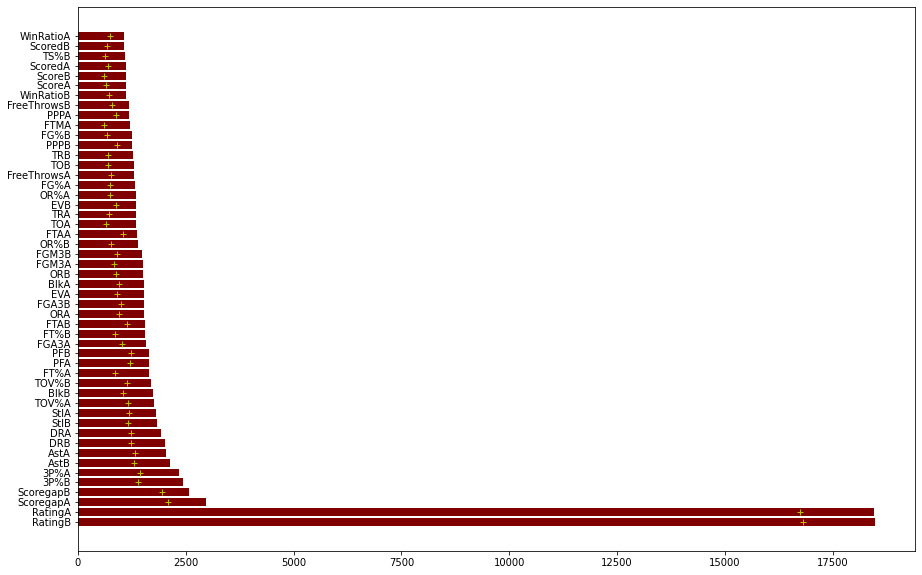

In [37]:

top = 50
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.barh(Best_valid.index[:top], Best_valid[:top], color ='maroon',)
plt.plot(Mean_valid[:top], Mean_valid.index[:top], 'y+')

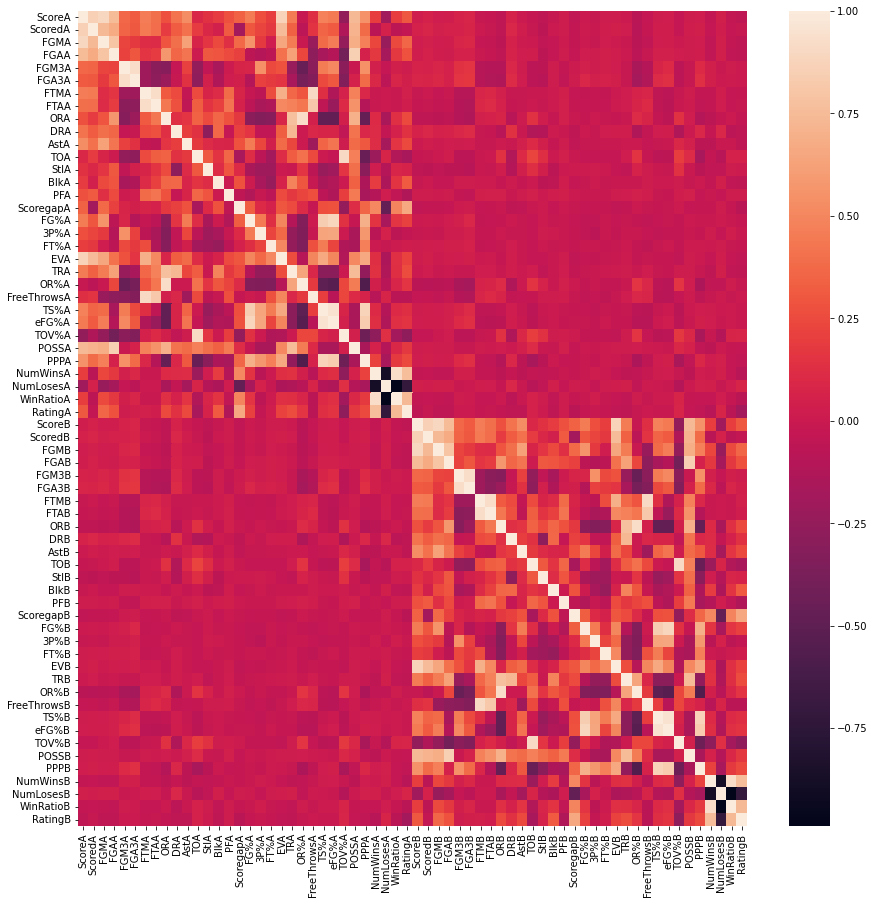

In [38]:
import seaborn as sns
plt.figure(figsize = (15,15))
corr = tourney_results[features].corr()
ax = sns.heatmap(corr) 

### V. Submission

In [39]:
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FG%A,3P%A,FT%A,EVA,TRA,OR%A,FreeThrowsA,TS%A,eFG%A,TOV%A,POSSA,PPPA,NumWinsA,NumLosesA,WinRatioA,RatingA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FG%B,3P%B,FT%B,EVB,TRB,OR%B,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,2021_1101_1104,0.5,2021,1101,1104,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,73.666667,70.729167,25.625000,63.354167,9.604167,29.187500,12.812500,18.166667,9.500000,24.854167,12.395833,14.458333,8.958333,3.770833,5.083333,2.937500,0.404472,0.329051,0.705275,22.561197,34.354167,0.149951,0.202236,0.516253,0.480270,0.168501,85.805833,0.858527,24.0,6.0,0.800000,92.297375
1,2021_1101_1111,0.5,2021,1101,1111,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,67.489510,68.405594,23.010490,57.248252,8.087413,25.160839,13.381119,18.706294,8.898601,21.891608,11.209790,11.108392,7.479021,3.146853,7.909091,-0.916084,0.401942,0.321429,0.715327,21.420290,30.790210,0.155439,0.233738,0.515352,0.472577,0.145042,76.587413,0.881209,13.0,11.0,0.541667,79.201104
2,2021_1101_1116,0.5,2021,1101,1116,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,78.189394,75.340909,28.204545,65.469697,7.303030,23.053030,14.477273,20.022727,10.787879,24.939394,13.378788,13.674242,8.204545,4.787879,3.537879,2.848485,0.430803,0.316793,0.723042,24.931827,35.727273,0.164777,0.221129,0.526317,0.486577,0.155470,87.953939,0.888981,22.0,6.0,0.785714,89.756430
3,2021_1101_1124,0.5,2021,1101,1124,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,76.022727,71.227273,28.772727,66.431818,8.363636,25.750000,10.113636,15.886364,12.772727,20.159091,14.068182,10.045455,7.159091,3.181818,12.636364,4.795455,0.433117,0.324801,0.636624,21.617050,32.931818,0.192268,0.152241,0.517712,0.496066,0.120352,83.467273,0.910809,22.0,2.0,0.916667,95.559039
4,2021_1101_1140,0.5,2021,1101,1140,71.348684,65.394737,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,5.953947,0.444344,0.354076,0.661238,22.116684,30.289474,0.147062,0.206045,0.537801,0.508515,0.168691,79.794211,0.894159,19.0,4.0,0.826087,82.271445,74.631579,72.942982,27.578947,59.859649,8.052632,22.938596,11.421053,15.372807,8.096491,26.986842,14.907895,13.057018,4.390351,2.552632,4.223684,1.688596,0.460727,0.351052,0.742939,24.018392,35.083333,0.135258,0.190797,0.560098,0.527989,0.163867,79.680702,0.936633,19.0,6.0,0.760000,87.895307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,2.

In [40]:
result = pd.read_csv("./2021NCAA.csv")
test["Predict"] = np.mean(y_test,axis=0)
pred = test[["TeamIdA","TeamIdB","Predict"]]

In [41]:
total = result.merge(pred,left_on=["TeamIdA","TeamIdB"],right_on=["TeamIdA","TeamIdB"])
total

,TeamIdA,TeamIdB,Result,Predict
0,1111,1313,0,0.621485
1,1179,1455,1,0.582330
2,1277,1417,0,0.303601
3,1140,1417,0,0.541142
4,1101,1417,0,0.348606
...,...,...,...,...
62,1160,1199,0,0.479605
63,1101,1400,1,0.192850
64,1163,1268,0,0.446862
65,1104,1233,1,0.867411


In [42]:
score = log_loss(total["Result"],total["Predict"])
score

0.5726595696888482